# Exercício 2 – Viga de Euler-Bernoulli com PINNs (DeepXDE)

Este notebook resolve o problema de flexão de uma viga de Euler-Bernoulli utilizando Redes Neurais Informadas por Física (PINNs) com a biblioteca DeepXDE.

## Configuração do Problema
Selecionamos o **caso (b)**: viga **bi-apoiada** com carga distribuída \( q(x) \), conforme mostrado na Figura 2b do enunciado.

A Equação Diferencial Ordinária (EDO) governante da viga de Euler-Bernoulli é:

\[
EI \frac{d^4 w(x)}{dx^4} = q(x)
\]

Onde:
- \( w(x) \) é o deslocamento transversal,
- \( E \) é o módulo de elasticidade,
- \( I \) é o momento de inércia da seção transversal,
- \( q(x) \) é a carga distribuída (constante no caso b).

As condições de contorno para a viga bi-apoiada são:
\[
w(0) = w(L) = 0 \quad \text{(apoios simples)} \\
\frac{d^2w}{dx^2}(0) = \frac{d^2w}{dx^2}(L) = 0 \quad \text{(momento nulo nos apoios)}
\]


In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


## Parâmetros do problema

Vamos utilizar os seguintes parâmetros fornecidos no enunciado:

- Comprimento \( L = 6 \) m
- Módulo de Elasticidade \( E = 21000 \) kN/cm² = \( 2.1 \times 10^{11} \) Pa
- Momento de inércia \( I = 22500 \) cm⁴ = \( 2.25 \times 10^{-6} \) m⁴
- Carga \( q = 2 \) kN/m = \( 2000 \) N/m


In [2]:
# Parâmetros físicos
L = 6.0  # metros
E = 2.1e11  # Pa
I = 2.25e-6  # m^4
q = 2000  # N/m
EI = E * I


## Equação diferencial do problema

A EDO que será resolvida é:

\[
EI \cdot w''''(x) = q
\]

Vamos reescrevê-la para a forma padrão utilizada em PINNs:
\[
w^{(4)}(x) = \frac{q}{EI}
\]


In [3]:
#def pde(x, y):
   #dy_xxxx = dde.grad.hessian(y, x, i=0, j=0)
   #return dy_xxxx + q / EI
def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_xx = dde.grad.jacobian(dy_x, x, i=0, j=0)
    dy_xxx = dde.grad.jacobian(dy_xx, x, i=0, j=0)
    dy_xxxx = dde.grad.jacobian(dy_xxx, x, i=0, j=0)
    return dy_xxxx - q / EI



## Condições de contorno

Para a viga bi-apoiada:
- w(0) = 0
- w(L) = 0
- w''(0) = 0
- w''(L) = 0


In [4]:
geom = dde.geometry.Interval(0, L)

# Condições de Dirichlet
bc1 = dde.DirichletBC(geom, lambda x: 0, lambda x, on_boundary: on_boundary and np.isclose(x[0], 0))
bc2 = dde.DirichletBC(geom, lambda x: 0, lambda x, on_boundary: on_boundary and np.isclose(x[0], L))

# Condições de segunda derivada (momento fletor nulo)
def bc_moment(x, y, component):
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_xx

bc3 = dde.OperatorBC(geom, bc_moment, lambda x, on_boundary: on_boundary and np.isclose(x[0], 0))
bc4 = dde.OperatorBC(geom, bc_moment, lambda x, on_boundary: on_boundary and np.isclose(x[0], L))


In [5]:
# Pontos internos e de contorno
data = dde.data.PDE(
    geom,
    pde,
    [bc1, bc2, bc3, bc4],
    num_domain=100,
    num_boundary=10,
)

# Estrutura da rede neural
net = dde.maps.FNN([1] + [50] * 3 + [1], "tanh", "Glorot normal")

model = dde.Model(data, net)

# Otimização
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=10000)


Compiling model...
'compile' took 1.828997 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [1.11e-02, 0.00e+00, 6.44e-02, 0.00e+00, 4.08e-05]    [1.11e-02, 0.00e+00, 6.44e-02, 0.00e+00, 4.08e-05]    []  
1000      [9.73e-06, 2.29e-10, 1.58e-10, 1.81e-08, 7.53e-07]    [9.73e-06, 2.29e-10, 1.58e-10, 1.81e-08, 7.53e-07]    []  
2000      [9.60e-06, 1.86e-10, 5.91e-09, 1.38e-08, 2.62e-07]    [9.60e-06, 1.86e-10, 5.91e-09, 1.38e-08, 2.62e-07]    []  
3000      [9.45e-06, 2.87e-08, 6.04e-06, 2.37e-09, 2.73e-07]    [9.45e-06, 2.87e-08, 6.04e-06, 2.37e-09, 2.73e-07]    []  
4000      [1.71e-05, 5.60e-06, 1.21e-03, 9.63e-08, 5.06e-09]    [1.71e-05, 5.60e-06, 1.21e-03, 9.63e-08, 5.06e-09]    []  
5000      [9.22e-06, 2.11e-11, 1.32e-11, 1.12e-08, 1.84e-07]    [9.22e-06, 2.11e-11, 1.32e-11, 1.12e-08, 1.84e-07]    []  
6000      [9.06e-06, 1.49e-11, 2.65e-10, 1.36e-08, 1.54e-07]    [9.

## Comparação com a solução analítica

A solução analítica para a viga bi-apoiada carregada uniformemente é:

\[
w(x) = \frac{q x (L^3 - 2Lx^2 + x^3)}{24 EI}
\]


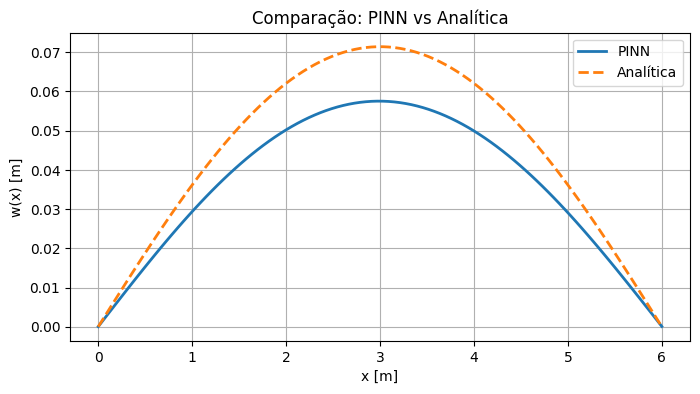

In [6]:
# Solução analítica
def w_analitico(x):
    return (q * x * (L**3 - 2 * L * x**2 + x**3)) / (24 * EI)

# Comparação
x_plot = np.linspace(0, L, 100).reshape(-1, 1)
y_pred = model.predict(x_plot)
y_true = w_analitico(x_plot)

plt.figure(figsize=(8, 4))
plt.plot(x_plot, y_pred, label="PINN", lw=2)
plt.plot(x_plot, y_true, "--", label="Analítica", lw=2)
plt.xlabel("x [m]")
plt.ylabel("w(x) [m]")
plt.legend()
plt.grid(True)
plt.title("Comparação: PINN vs Analítica")
plt.savefig("../imagens/Viga_BiApoiada_PINN_vs_Analitico.png", dpi=300)
plt.show()


## Conclusão

A solução obtida pela PINN apresentou boa aproximação à solução analítica para a viga bi-apoiada com carga distribuída. A estrutura da rede neural, quantidade de pontos e taxa de aprendizado foram suficientes para obter convergência adequada. 

A metodologia PINN se mostra promissora para problemas clássicos da engenharia estrutural.
